# Learning State
This notebook deals with learning the state of a device from the current information at each point in the voltage space.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import glob

## Loading the data
[Change the data path when loading from a different folder]

In [30]:
data_path = "/Users/sandesh/data/QFlow/data_for_paper/double_dot_low_var/"
files = glob.glob(data_path + "*.npy")
print(len(files))

1060


### Sample Data

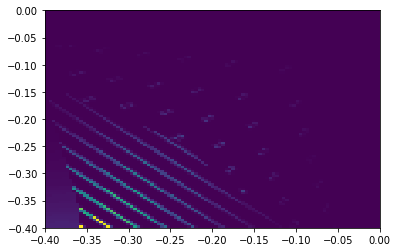

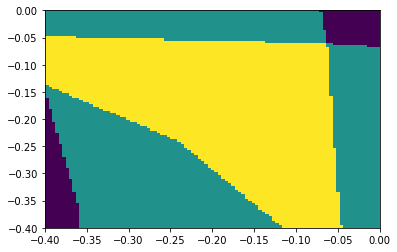

In [31]:
import random
sample_data = np.load(random.choice(files)).item()

V_P1_vec = sample_data['V_P1_vec']
V_P2_vec = sample_data['V_P2_vec']
N_v = len(V_P1_vec)
current = np.array([x['current'] for x in sample_data['output']]).reshape(N_v,N_v)
state = np.array([x['state'] for x in sample_data['output']]).reshape(N_v,N_v)

XX,YY = np.meshgrid(V_P1_vec,V_P2_vec)
plt.figure(1)
plt.pcolor(XX,YY,1e6*current)
plt.figure(2)
plt.pcolor(XX,YY,state)

### Load the entire dataset
The current and the state maps will be loaded in a single array.

In [32]:
inp_array = []
out_array = []
for file in files:
    dat = np.load(file).item() 
    inp_array.append(np.array([x['current'] for x in dat['output']]))
    out_array.append(np.array([x['state'] for x in dat['output']]))
inp_array = np.array(inp_array)
out_array = np.array(out_array)

## Define CNN 

The CNN takes in the current information as the input and provides the state information as the output.

In [35]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features,[-1,100,100,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=8,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    #conv2 = tf.layers.conv2d(inputs=pool1,
    #                        filters=16,
    #                        kernel_size=[5,5],
    #                        padding="same",
    #                        activation=tf.nn.relu)
    #pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool1)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=64,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout1, units=10000)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "states" : tf.rint(out),
    }

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


## Divide the dataset into training and test data

In [37]:
# determines the number of inputs used as the training set
# the rest are treated as a test set
train_factor = 0.9

n_tot = inp_array.shape[0]
n_train = int(train_factor*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)

x_train_data = inp_array[:n_train]
y_train_data = out_array[:n_train].astype(int)
x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

Number of inputs: 10000
Number of outputs: 10000
Total, Training, Test
1060 954 106


## Define the input  functions

In [46]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x" : x_train_data},
    y=y_train_data,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

def get_train_inputs():
    # load a random batch of batch_size to perform the training
    batch_size = 100
    idx = np.random.randint(n_train,size=batch_size)
    
    batch_in_data = inp_array[idx,:]
    batch_out_data = out_array[idx,:].astype(int)
    x = tf.constant(batch_in_data)
    y = tf.constant(batch_out_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y


## Train the CNN

In [47]:
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
state_classifier.train(input_fn=get_train_inputs,steps=20000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_task_id': 0, '_num_worker_replicas': 1, '_task_type': 'worker', '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11a5c8978>, '_tf_random_seed': None, '_session_config': None, '_is_chief': True, '_master': '', '_model_dir': '/var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpeasvxc7l', '_service': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpeasvxc7l/model.ckpt.
INFO:tensorflow:step = 1, loss = 1.93935
INFO:tensorflow:global_step/sec: 1.5363
INFO:tensorflow:step = 101, loss = 1.93935 (65.097 sec)
INFO:tensorflow:global_step/sec: 1.64725
INFO:tensorflow:step = 201, loss = 1.93

INFO:tensorflow:global_step/sec: 1.59849
INFO:tensorflow:step = 6801, loss = 1.93475 (62.564 sec)
INFO:tensorflow:global_step/sec: 1.59968
INFO:tensorflow:step = 6901, loss = 1.93466 (62.510 sec)
INFO:tensorflow:global_step/sec: 1.60621
INFO:tensorflow:step = 7001, loss = 1.93459 (62.258 sec)
INFO:tensorflow:Saving checkpoints for 7059 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpeasvxc7l/model.ckpt.
INFO:tensorflow:global_step/sec: 1.59145
INFO:tensorflow:step = 7101, loss = 1.9345 (62.832 sec)
INFO:tensorflow:global_step/sec: 1.61598
INFO:tensorflow:step = 7201, loss = 1.93442 (61.883 sec)
INFO:tensorflow:global_step/sec: 1.58322
INFO:tensorflow:step = 7301, loss = 1.93434 (63.175 sec)
INFO:tensorflow:global_step/sec: 1.60913
INFO:tensorflow:step = 7401, loss = 1.93425 (62.135 sec)
INFO:tensorflow:global_step/sec: 1.6197
INFO:tensorflow:step = 7501, loss = 1.93418 (61.737 sec)
INFO:tensorflow:global_step/sec: 1.61596
INFO:tensorflow:step = 7601, loss = 1.93409 (61.886 sec

INFO:tensorflow:step = 14101, loss = 1.92926 (57.431 sec)
INFO:tensorflow:global_step/sec: 1.76506
INFO:tensorflow:step = 14201, loss = 1.92919 (56.655 sec)
INFO:tensorflow:global_step/sec: 1.75235
INFO:tensorflow:step = 14301, loss = 1.92912 (57.069 sec)
INFO:tensorflow:global_step/sec: 1.76099
INFO:tensorflow:step = 14401, loss = 1.92903 (56.784 sec)
INFO:tensorflow:global_step/sec: 1.76168
INFO:tensorflow:step = 14501, loss = 1.92895 (56.764 sec)
INFO:tensorflow:global_step/sec: 1.76341
INFO:tensorflow:step = 14601, loss = 1.92888 (56.711 sec)
INFO:tensorflow:global_step/sec: 1.72104
INFO:tensorflow:step = 14701, loss = 1.92881 (58.103 sec)
INFO:tensorflow:global_step/sec: 1.59467
INFO:tensorflow:step = 14801, loss = 1.92873 (62.713 sec)
INFO:tensorflow:global_step/sec: 1.62341
INFO:tensorflow:step = 14901, loss = 1.92866 (61.593 sec)
INFO:tensorflow:global_step/sec: 1.63047
INFO:tensorflow:step = 15001, loss = 1.92858 (61.336 sec)
INFO:tensorflow:Saving checkpoints for 15045 into /

## Evaluate the Model

In [ ]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test_data},
    y=y_test_data,
    num_epochs=1,
    shuffle=False)
eval_results = state_classifier.evaluate(input_fn=get_test_inputs)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-11-26-09:38:37
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpeasvxc7l/model.ckpt-20000
